In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import csv

import torch
import captum
from captum.attr import IntegratedGradients
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
# import argparse


# parser = argparse.ArgumentParser(description="Run script with optional CU and DU values.")
# parser.add_argument("--cu", type=int, default=0, help="CU value (default: 0)")
# parser.add_argument("--du", type=int, default=0, help="DU value (default: 0)")

# args = parser.parse_args()

# CU, DU = args.cu, args.du

CU = 0
DU = 0

# Load dataset
dataset = pd.read_csv(f'dataset_srscu{CU}_srsdu{DU}.csv')
# dataset = dataset[:int(0.01*len(dataset))]

dataset.index = dataset['Timestamp']
dataset = dataset.drop(columns=['Timestamp'])

dataset.head()

,"((node_memory_MemTotal_bytes{instance=""node-exporter:9100"", job=""node""} - node_memory_MemFree_bytes{instance=""node-exporter:9100"", job=""node""}) / node_memory_MemTotal_bytes{instance=""node-exporter:9100"", job=""node""}) * 100","((node_memory_SwapTotal_bytes{instance=""node-exporter:9100"",job=""node""} - node_memory_SwapFree_bytes{instance=""node-exporter:9100"",job=""node""}) / (node_memory_SwapTotal_bytes{instance=""node-exporter:9100"",job=""node""})) * 100","((sum(container_memory_usage_bytes{name=""srscu"",instance=""cadvisor:8080""}) by (instance) - sum(container_memory_cache{name=""srscu"",instance=""cadvisor:8080""}) by (instance)) / sum(machine_memory_bytes{instance=""cadvisor:8080""}) by (instance)) * 100","((sum(container_memory_usage_bytes{name=""srsdu"",instance=""cadvisor:8080""}) by (instance) - sum(container_memory_cache{name=""srsdu"",instance=""cadvisor:8080""}) by (instance)) / sum(machine_memory_bytes{instance=""cadvisor:8080""}) by (instance)) * 100","(1 - (node_memory_MemAvailable_bytes{instance=""node-exporter:9100"", job=""node""} / node_memory_MemTotal_bytes{instance=""node-exporter:9100"", job=""node""})) * 100","(node_memory_SwapTotal_bytes{instance=""node-exporter:9100"",job=""node""} - node_memory_SwapFree_bytes{instance=""node-exporter:9100"",job=""node""})","100 * (1 - avg(rate(node_cpu_seconds_total{mode=""idle"", instance=""node-exporter:9100""}[10s])))","100 - ((node_filesystem_avail_bytes{instance=""node-exporter:9100"",job=""node"",device!~'rootfs'} * 100) / node_filesystem_size_bytes{instance=""node-exporter:9100"",job=""node"",device!~'rootfs'})","100 - ((node_filesystem_avail_bytes{instance=""node-exporter:9100"",job=""node"",mountpoint=""/"",fstype!=""rootfs""} * 100) / node_filesystem_size_bytes{instance=""node-exporter:9100"",job=""node"",mountpoint=""/"",fstype!=""rootfs""})","avg(node_cpu_scaling_frequency_max_hertz{instance=""node-exporter:9100"",job=""node""})",...,PCI-4_Average_pusch_ta_ns,PCI-4_Average_pucch_ta_ns,PCI-4_Summation_ul_nof_ok,PCI-4_Summation_ul_nof_nok,PCI-4_Summation_dl_nof_nok,PCI-4_Summation_ul_brate,PCI-4_Summation_dl_bs,PCI-4_Summation_bsr,PCI-4_Summation_dl_brate,PCI-4_Summation_dl_nof_ok
Timestamp,,,,,,,,,,,,,,,,,,,,,
2025-05-23 12:58:38.769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-23 12:58:39.769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-23 12:58:40.770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-23 12:58:41.819,NaN,NaN,0.408751,0.454471,NaN,NaN,84.108545,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-23 12:58:42.820,NaN,NaN,0.408947,0.454973,NaN,NaN,75.533914,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
features = dataset.drop(columns=[f"srscu_stepStress", f"srscu_stressType", f"srsdu_stepStress", f"srsdu_stressType"])
targets = dataset[[f"srscu_stepStress", f"srscu_stressType", f"srsdu_stepStress", f"srsdu_stressType"]]

# Imputing

In [12]:
# **Data Preprocessing**
# Handle missing values
features = features.apply(lambda x: x.fillna(0) if x.isna().all() else x)


threshold = 0.6 * len(features)
features = features.loc[:, ~features.columns.duplicated()]  # Remove duplicates

for col in features.columns:
    nan_count = features[col].isna().sum()
    if int(nan_count) > threshold:  # Explicit scalar conversion
        mode_value = features[col].mode().iloc[0] if not features[col].mode().empty else 0
        features[col].fillna(mode_value, inplace=True)

numeric_cols = features.select_dtypes(include=[np.number]).columns
features[numeric_cols] = features[numeric_cols].fillna(features[numeric_cols].mean())

In [13]:
# Scale features
scaler = MinMaxScaler(feature_range=(-1, 1))
features_scaled = scaler.fit_transform(features)

# Convert scaled features back to DataFrame
features_scaled = pd.DataFrame(features_scaled, columns=features.columns)
features_scaled.index = features.index

import joblib

# Save the scaler
joblib.dump(scaler, 'minmax_scaler.pkl')

['minmax_scaler.pkl']

Optimal PCA dimension: 5


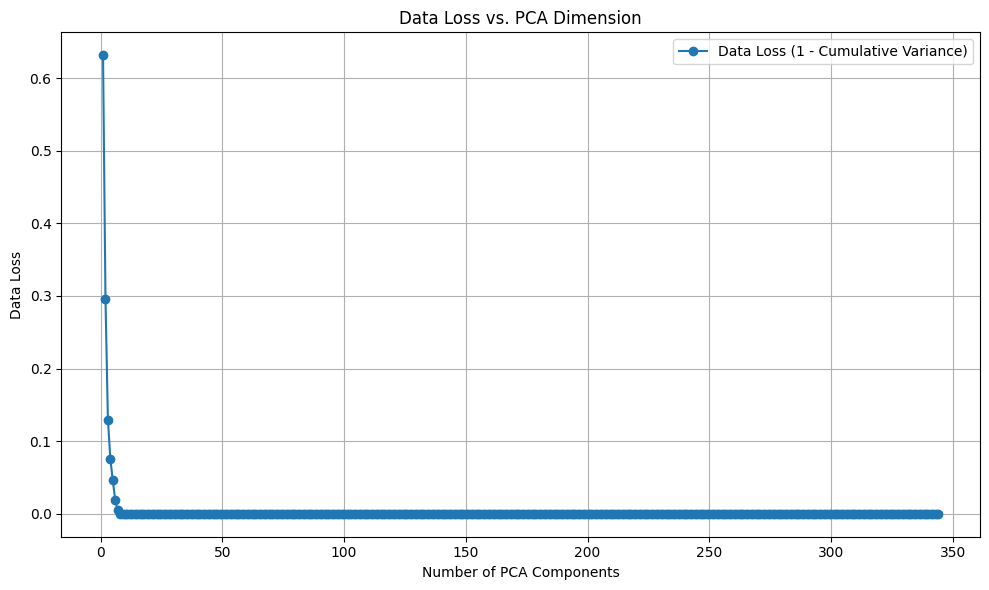

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def plot_pca_data_loss(features_scaled):
    """
    Plots how much data (variance) is lost for different PCA dimensions.

    Parameters:
    - features_scaled: ndarray, standardized feature matrix.
    """
    pca = PCA()
    pca.fit(features_scaled)

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    data_loss = 1 - cumulative_variance

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(data_loss)+1), data_loss, marker='o', label='Data Loss (1 - Cumulative Variance)')
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Data Loss')
    plt.title('Data Loss vs. PCA Dimension')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('pca_data_loss.png')


def find_optimal_pca_dimension(features_scaled, variance_threshold=0.95):
    """
    Finds the optimal number of PCA components to retain the desired amount of explained variance.

    Parameters:
    - features_scaled: ndarray, the standardized feature matrix.
    - variance_threshold: float, the target cumulative explained variance (default is 0.95).

    Returns:
    - optimal_components: int, the number of components needed to retain the threshold variance.
    - explained_variance: ndarray, the cumulative explained variance.
    """
    pca = PCA()
    pca.fit(features_scaled)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    return optimal_components, cumulative_variance

plot_pca_data_loss(features_scaled)


PCA_DIMENSION, _ = find_optimal_pca_dimension(features_scaled, variance_threshold=0.95)
print(f"Optimal PCA dimension: {PCA_DIMENSION}")


In [15]:
pca = PCA(n_components=PCA_DIMENSION)
# Apply PCA
features_pca = pca.fit_transform(features_scaled)

# Save the PCA model
joblib.dump(pca, 'pca_model.pkl')

# Convert PCA features back to DataFrame
features_pca = pd.DataFrame(features_pca, columns=[f'Reduced-{i+1}' for i in range(PCA_DIMENSION)])
features_pca.index = features_scaled.index

# Adding targets back to the PCA features DataFrame
pca_dataset = pd.concat([features_pca, targets], axis=1)

# Save the PCA-transformed features
pca_dataset.to_csv(f'dataset_srscu{CU}_srsdu{DU}_pca.csv', index=True)